# Skin Lesion Classification — Transfer Learning template
**Dataset:** merged HAM10000 + MSLDv2.0 (14 classes).

This notebook trains a single transfer-learning model on the dataset using PyTorch. 
**Assumptions:** dataset arranged like:
```
data/
  train/
    class_1/
      img1.jpg
      img2.jpg
    class_2/
  val/
    class_1/
    ...
```
If your dataset is packaged differently, adapt `train_dir` / `val_dir` variables below.

This notebook was autogenerated to match SE4050 assignment requirements (4 different model notebooks will be provided).
\n\n**Model:** MobileNetV3-Large

In [1]:
# Environment & imports
# If running in a fresh environment, you may need to install packages:
# !pip install torch torchvision matplotlib scikit-learn tqdm timm -q
%pip install torch torchvision matplotlib scikit-learn tqdm timm
import os
import time
import copy
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms, datasets, models

from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)


Note: you may need to restart the kernel to use updated packages.
Device: cpu


In [2]:
# Paths (change these to your dataset locations)
# Download and extract your dataset folders locally, then set the paths below:
train_dir = r"C:\Users\ashan\Downloads\DL-20251011T135953Z-1-001\DL\train"  # Example local path
val_dir   = r"C:\Users\ashan\Downloads\DL-20251011T135953Z-1-001\DL\val"    # Example local path

# Data transforms and augmentation
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

train_dataset = datasets.ImageFolder(train_dir, transform=train_transforms)
val_dataset   = datasets.ImageFolder(val_dir, transform=val_transforms)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

class_names = train_dataset.classes
num_classes = len(class_names)
print("Classes ({}):".format(num_classes), class_names)
print("Train size:", len(train_dataset), " Val size:", len(val_dataset))


Classes (10): ['Actinic keratoses', 'Chickenpox', 'Cowpox', 'Dermatofibroma', 'HFMD', 'Healthy', 'Measles', 'Monkeypox', 'Squamous cell carcinoma', 'Vascular lesions']
Train size: 10648  Val size: 1327


In [3]:
# Compute class weights to address imbalance
from collections import Counter
counts = Counter([y for _, y in train_dataset.samples])
counts = [counts[i] for i in range(len(class_names))]
print("Class counts:", counts)
class_weights = torch.tensor([sum(counts)/c for c in counts], dtype=torch.float).to(device)
print("Class weights:", class_weights)

criterion = nn.CrossEntropyLoss(weight=class_weights)


Class counts: [693, 900, 792, 191, 1932, 1368, 660, 3408, 502, 202]
Class weights: tensor([15.3651, 11.8311, 13.4444, 55.7487,  5.5114,  7.7836, 16.1333,  3.1244,
        21.2112, 52.7129])


In [4]:
# MobileNetV3 Large (pretrained)
try:
    model = models.mobilenet_v3_large(pretrained=True)
    # Correctly identify the input features for the classifier
    num_ftrs = model.classifier[-1].in_features  # Access the last layer of the classifier
    model.classifier[-1] = nn.Linear(num_ftrs, num_classes)
except Exception as e:
    # Fallback for older torchvision versions or different model structures
    model = models.mobilenet_v3_large(pretrained=True)
    # Attempt to access the in_features from the first layer if the above fails
    try:
        num_ftrs = model.classifier[0].in_features
        model.classifier[0] = nn.Linear(num_ftrs, num_classes)
    except Exception as e_fallback:
        print(f"Could not adapt classifier automatically: {e_fallback}")
        print("Please check the model's classifier structure and adapt the code manually.")

model = model.to(device)

c:\Users\ashan\miniconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\ashan\miniconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Large_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Large_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [5]:
# Optimizer, scheduler
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
# Optional scheduler
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
scheduler = None
num_epochs = 30  # change as needed


In [7]:
def train_model(model, criterion, optimizer, scheduler=None, num_epochs=30, model_name="model"):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_f1 = 0.0

    history = {"train_loss":[],"val_loss":[],"train_acc":[],"val_acc":[], "val_f1":[]}

    for epoch in range(num_epochs):
        print("Epoch {}/{}".format(epoch+1, num_epochs))
        # Each epoch has a training and validation phase
        for phase in ["train","val"]:
            if phase == "train":
                model.train()
                loader = train_loader
            else:
                model.eval()
                loader = val_loader

            running_loss = 0.0
            running_corrects = 0
            y_true = []
            y_pred = []

            for inputs, labels in tqdm(loader):
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()
                with torch.set_grad_enabled(phase == "train"):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == "train":
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data).item()
                y_true.extend(labels.cpu().numpy().tolist())
                y_pred.extend(preds.cpu().numpy().tolist())

            epoch_loss = running_loss / (len(loader.dataset))
            epoch_acc = running_corrects / (len(loader.dataset))
            epoch_f1 = f1_score(y_true, y_pred, average='macro')
            print("{} Loss: {:.4f} Acc: {:.4f} F1: {:.4f}".format(phase, epoch_loss, epoch_acc, epoch_f1))

            if phase == "train":
                history["train_loss"].append(epoch_loss)
                history["train_acc"].append(epoch_acc)
            else:
                history["val_loss"].append(epoch_loss)
                history["val_acc"].append(epoch_acc)
                history["val_f1"].append(epoch_f1)
                # deep copy the model
                if epoch_f1 > best_f1:
                    best_f1 = epoch_f1
                    best_model_wts = copy.deepcopy(model.state_dict())
                    torch.save(model.state_dict(), f"{model_name}_best.pth")
        if scheduler is not None:
            scheduler.step()
        print("-"*30)

    time_elapsed = time.time() - since
    print("Training complete in {:.0f}m {:.0f}s".format(time_elapsed // 60, time_elapsed % 60))
    print("Best val F1: {:.4f}".format(best_f1))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, history


In [8]:
# Train
model, history = train_model(model, criterion, optimizer, scheduler, num_epochs=num_epochs, model_name="MobileNetV3-Large")


Epoch 1/30


100%|██████████| 333/333 [16:56<00:00,  3.05s/it]


train Loss: 1.1473 Acc: 0.5467 F1: 0.5242


100%|██████████| 42/42 [00:55<00:00,  1.32s/it]


val Loss: 0.6955 Acc: 0.7227 F1: 0.7285
------------------------------
Epoch 2/30


100%|██████████| 333/333 [15:28<00:00,  2.79s/it]


train Loss: 0.6414 Acc: 0.7228 F1: 0.7094


100%|██████████| 42/42 [00:48<00:00,  1.16s/it]


val Loss: 0.4393 Acc: 0.8289 F1: 0.8299
------------------------------
Epoch 3/30


100%|██████████| 333/333 [14:33<00:00,  2.62s/it]


train Loss: 0.5176 Acc: 0.7788 F1: 0.7658


100%|██████████| 42/42 [00:53<00:00,  1.27s/it]


val Loss: 0.3512 Acc: 0.8696 F1: 0.8471
------------------------------
Epoch 4/30


100%|██████████| 333/333 [15:51<00:00,  2.86s/it]


train Loss: 0.4252 Acc: 0.8209 F1: 0.8094


100%|██████████| 42/42 [00:50<00:00,  1.20s/it]


val Loss: 0.3391 Acc: 0.8696 F1: 0.8617
------------------------------
Epoch 5/30


100%|██████████| 333/333 [16:13<00:00,  2.92s/it]


train Loss: 0.3970 Acc: 0.8395 F1: 0.8237


100%|██████████| 42/42 [00:51<00:00,  1.22s/it]


val Loss: 0.2583 Acc: 0.9005 F1: 0.9033
------------------------------
Epoch 6/30


100%|██████████| 333/333 [15:55<00:00,  2.87s/it]


train Loss: 0.3567 Acc: 0.8508 F1: 0.8394


100%|██████████| 42/42 [00:49<00:00,  1.17s/it]


val Loss: 0.2207 Acc: 0.9201 F1: 0.9178
------------------------------
Epoch 7/30


100%|██████████| 333/333 [16:07<00:00,  2.91s/it]


train Loss: 0.3273 Acc: 0.8684 F1: 0.8567


100%|██████████| 42/42 [00:47<00:00,  1.12s/it]


val Loss: 0.2041 Acc: 0.9216 F1: 0.8944
------------------------------
Epoch 8/30


100%|██████████| 333/333 [16:00<00:00,  2.88s/it]


train Loss: 0.3013 Acc: 0.8778 F1: 0.8644


100%|██████████| 42/42 [00:50<00:00,  1.21s/it]


val Loss: 0.1957 Acc: 0.9209 F1: 0.9168
------------------------------
Epoch 9/30


100%|██████████| 333/333 [15:52<00:00,  2.86s/it]


train Loss: 0.2709 Acc: 0.8912 F1: 0.8837


100%|██████████| 42/42 [00:45<00:00,  1.08s/it]


val Loss: 0.1642 Acc: 0.9352 F1: 0.9187
------------------------------
Epoch 10/30


100%|██████████| 333/333 [15:53<00:00,  2.86s/it]


train Loss: 0.2673 Acc: 0.8971 F1: 0.8868


100%|██████████| 42/42 [00:48<00:00,  1.16s/it]


val Loss: 0.1774 Acc: 0.9307 F1: 0.9141
------------------------------
Epoch 11/30


100%|██████████| 333/333 [16:03<00:00,  2.89s/it]


train Loss: 0.2411 Acc: 0.9030 F1: 0.8962


100%|██████████| 42/42 [00:49<00:00,  1.17s/it]


val Loss: 0.1516 Acc: 0.9450 F1: 0.9202
------------------------------
Epoch 12/30


100%|██████████| 333/333 [15:59<00:00,  2.88s/it]


train Loss: 0.2353 Acc: 0.9086 F1: 0.8970


100%|██████████| 42/42 [00:49<00:00,  1.17s/it]


val Loss: 0.1508 Acc: 0.9450 F1: 0.9240
------------------------------
Epoch 13/30


100%|██████████| 333/333 [16:04<00:00,  2.90s/it]


train Loss: 0.2291 Acc: 0.9116 F1: 0.9027


100%|██████████| 42/42 [00:49<00:00,  1.19s/it]


val Loss: 0.1372 Acc: 0.9472 F1: 0.9246
------------------------------
Epoch 14/30


100%|██████████| 333/333 [16:05<00:00,  2.90s/it]


train Loss: 0.2066 Acc: 0.9155 F1: 0.9058


100%|██████████| 42/42 [00:45<00:00,  1.09s/it]


val Loss: 0.1729 Acc: 0.9405 F1: 0.9037
------------------------------
Epoch 15/30


100%|██████████| 333/333 [15:54<00:00,  2.86s/it]


train Loss: 0.1964 Acc: 0.9174 F1: 0.9116


100%|██████████| 42/42 [00:45<00:00,  1.09s/it]


val Loss: 0.1583 Acc: 0.9488 F1: 0.9286
------------------------------
Epoch 16/30


100%|██████████| 333/333 [16:09<00:00,  2.91s/it]


train Loss: 0.2118 Acc: 0.9177 F1: 0.9071


100%|██████████| 42/42 [00:47<00:00,  1.13s/it]


val Loss: 0.1296 Acc: 0.9488 F1: 0.9271
------------------------------
Epoch 17/30


100%|██████████| 333/333 [16:19<00:00,  2.94s/it]


train Loss: 0.1823 Acc: 0.9292 F1: 0.9212


100%|██████████| 42/42 [00:46<00:00,  1.12s/it]


val Loss: 0.1470 Acc: 0.9548 F1: 0.9282
------------------------------
Epoch 18/30


100%|██████████| 333/333 [16:03<00:00,  2.89s/it]


train Loss: 0.1895 Acc: 0.9293 F1: 0.9229


100%|██████████| 42/42 [00:50<00:00,  1.20s/it]


val Loss: 0.1293 Acc: 0.9608 F1: 0.9374
------------------------------
Epoch 19/30


100%|██████████| 333/333 [16:07<00:00,  2.91s/it]


train Loss: 0.1902 Acc: 0.9294 F1: 0.9187


100%|██████████| 42/42 [00:50<00:00,  1.20s/it]


val Loss: 0.1390 Acc: 0.9518 F1: 0.9366
------------------------------
Epoch 20/30


100%|██████████| 333/333 [15:58<00:00,  2.88s/it]


train Loss: 0.1690 Acc: 0.9320 F1: 0.9295


100%|██████████| 42/42 [00:50<00:00,  1.20s/it]


val Loss: 0.2083 Acc: 0.9442 F1: 0.9044
------------------------------
Epoch 21/30


100%|██████████| 333/333 [15:58<00:00,  2.88s/it]


train Loss: 0.1592 Acc: 0.9360 F1: 0.9323


100%|██████████| 42/42 [00:49<00:00,  1.19s/it]


val Loss: 0.1374 Acc: 0.9533 F1: 0.9356
------------------------------
Epoch 22/30


100%|██████████| 333/333 [16:04<00:00,  2.90s/it]


train Loss: 0.1675 Acc: 0.9336 F1: 0.9266


100%|██████████| 42/42 [00:50<00:00,  1.20s/it]


val Loss: 0.1358 Acc: 0.9593 F1: 0.9269
------------------------------
Epoch 23/30


100%|██████████| 333/333 [16:06<00:00,  2.90s/it]


train Loss: 0.1578 Acc: 0.9344 F1: 0.9308


100%|██████████| 42/42 [00:50<00:00,  1.21s/it]


val Loss: 0.1204 Acc: 0.9616 F1: 0.9452
------------------------------
Epoch 24/30


100%|██████████| 333/333 [16:11<00:00,  2.92s/it]


train Loss: 0.1603 Acc: 0.9381 F1: 0.9350


100%|██████████| 42/42 [00:46<00:00,  1.11s/it]


val Loss: 0.1281 Acc: 0.9608 F1: 0.9458
------------------------------
Epoch 25/30


100%|██████████| 333/333 [16:02<00:00,  2.89s/it]


train Loss: 0.1493 Acc: 0.9403 F1: 0.9354


100%|██████████| 42/42 [00:50<00:00,  1.20s/it]


val Loss: 0.1226 Acc: 0.9699 F1: 0.9595
------------------------------
Epoch 26/30


100%|██████████| 333/333 [16:06<00:00,  2.90s/it]


train Loss: 0.1430 Acc: 0.9454 F1: 0.9380


100%|██████████| 42/42 [00:46<00:00,  1.10s/it]


val Loss: 0.1514 Acc: 0.9540 F1: 0.9403
------------------------------
Epoch 27/30


100%|██████████| 333/333 [16:00<00:00,  2.88s/it]


train Loss: 0.1458 Acc: 0.9446 F1: 0.9383


100%|██████████| 42/42 [00:49<00:00,  1.18s/it]


val Loss: 0.1052 Acc: 0.9676 F1: 0.9403
------------------------------
Epoch 28/30


100%|██████████| 333/333 [16:08<00:00,  2.91s/it]


train Loss: 0.1482 Acc: 0.9411 F1: 0.9357


100%|██████████| 42/42 [00:50<00:00,  1.21s/it]


val Loss: 0.1128 Acc: 0.9683 F1: 0.9492
------------------------------
Epoch 29/30


100%|██████████| 333/333 [16:20<00:00,  2.94s/it]


train Loss: 0.1258 Acc: 0.9491 F1: 0.9483


100%|██████████| 42/42 [00:51<00:00,  1.23s/it]


val Loss: 0.1380 Acc: 0.9608 F1: 0.9374
------------------------------
Epoch 30/30


100%|██████████| 333/333 [16:16<00:00,  2.93s/it]


train Loss: 0.1180 Acc: 0.9534 F1: 0.9494


100%|██████████| 42/42 [00:49<00:00,  1.17s/it]

val Loss: 0.1101 Acc: 0.9736 F1: 0.9574
------------------------------
Training complete in 505m 38s
Best val F1: 0.9595


In [9]:
def plot_history(history, model_name="model"):
    epochs = range(1, len(history["train_loss"]) + 1)
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.plot(epochs, history["train_loss"], label="train_loss")
    plt.plot(epochs, history["val_loss"], label="val_loss")
    plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.legend(); plt.title(f"{model_name} Loss")

    plt.subplot(1,2,2)
    plt.plot(epochs, history["train_acc"], label="train_acc")
    plt.plot(epochs, history["val_acc"], label="val_acc")
    plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.legend(); plt.title(f"{model_name} Accuracy")
    plt.show()


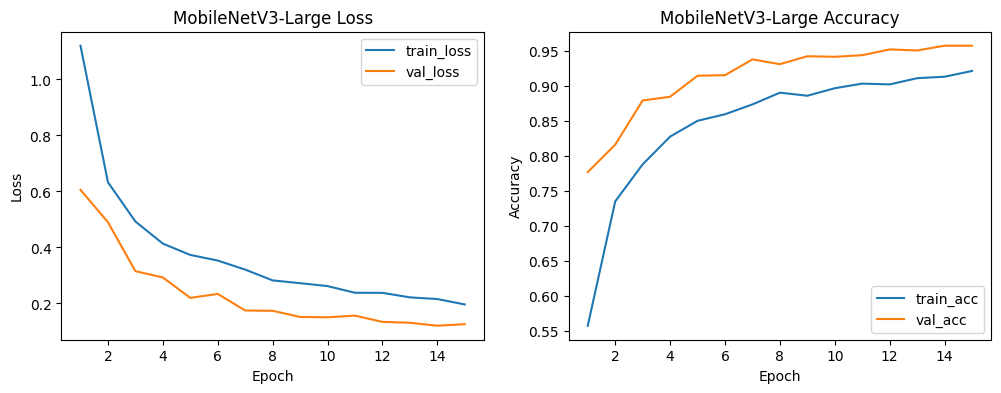

In [26]:
plot_history(history, model_name="MobileNetV3-Large")


In [10]:
# Load best model checkpoint (if needed) and run final evaluation on validation set
def evaluate_model(model):
    model.eval()
    y_true = []
    y_pred = []
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy().tolist())
            y_pred.extend(preds.cpu().numpy().tolist())
    
    # Fix sklearn warnings by setting zero_division parameter
    print(classification_report(y_true, y_pred, target_names=class_names, zero_division=0))
    cm = confusion_matrix(y_true, y_pred)
    print("Confusion matrix:\n", cm)

In [28]:
evaluate_model(model)

                         precision    recall  f1-score   support

      Actinic keratoses       0.87      0.87      0.87        86
             Chickenpox       0.96      0.98      0.97       112
                 Cowpox       0.99      0.96      0.97        99
         Dermatofibroma       0.96      0.96      0.96        23
                   HFMD       0.93      1.00      0.97       241
                Healthy       0.98      0.98      0.98       171
                Measles       1.00      0.94      0.97        82
              Monkeypox       0.98      0.96      0.97       426
Squamous cell carcinoma       0.82      0.81      0.81        62
       Vascular lesions       0.96      1.00      0.98        25

               accuracy                           0.96      1327
              macro avg       0.95      0.95      0.95      1327
           weighted avg       0.96      0.96      0.96      1327

Confusion matrix:
 [[ 75   0   0   0   0   0   0   0  11   0]
 [  0 110   0   0   0   0

Note: you may need to restart the kernel to use updated packages.
Test classes order: ['Actinic keratoses', 'Chickenpox', 'Cowpox', 'Dermatofibroma', 'HFMD', 'Healthy', 'Measles', 'Monkeypox', 'Squamous cell carcinoma', 'Vascular lesions']
Test size: 1337

Test set class distribution:
  Actinic keratoses: 88
  Chickenpox: 113
  Cowpox: 99
  Dermatofibroma: 25
  HFMD: 242
  Healthy: 171
  Measles: 83
  Monkeypox: 426
  Squamous cell carcinoma: 64
  Vascular lesions: 26

✅ Loaded checkpoint: MobileNetV3-Large_best.pth

TEST SET EVALUATION RESULTS
Overall Accuracy: 0.957
F1 Score (Macro): 0.938
F1 Score (Weighted): 0.958

Detailed Classification Report:
                         precision    recall  f1-score   support

      Actinic keratoses       0.89      0.82      0.85        88
             Chickenpox       0.92      0.98      0.95       113
                 Cowpox       0.99      0.98      0.98        99
         Dermatofibroma       0.95      0.80      0.87        25
               

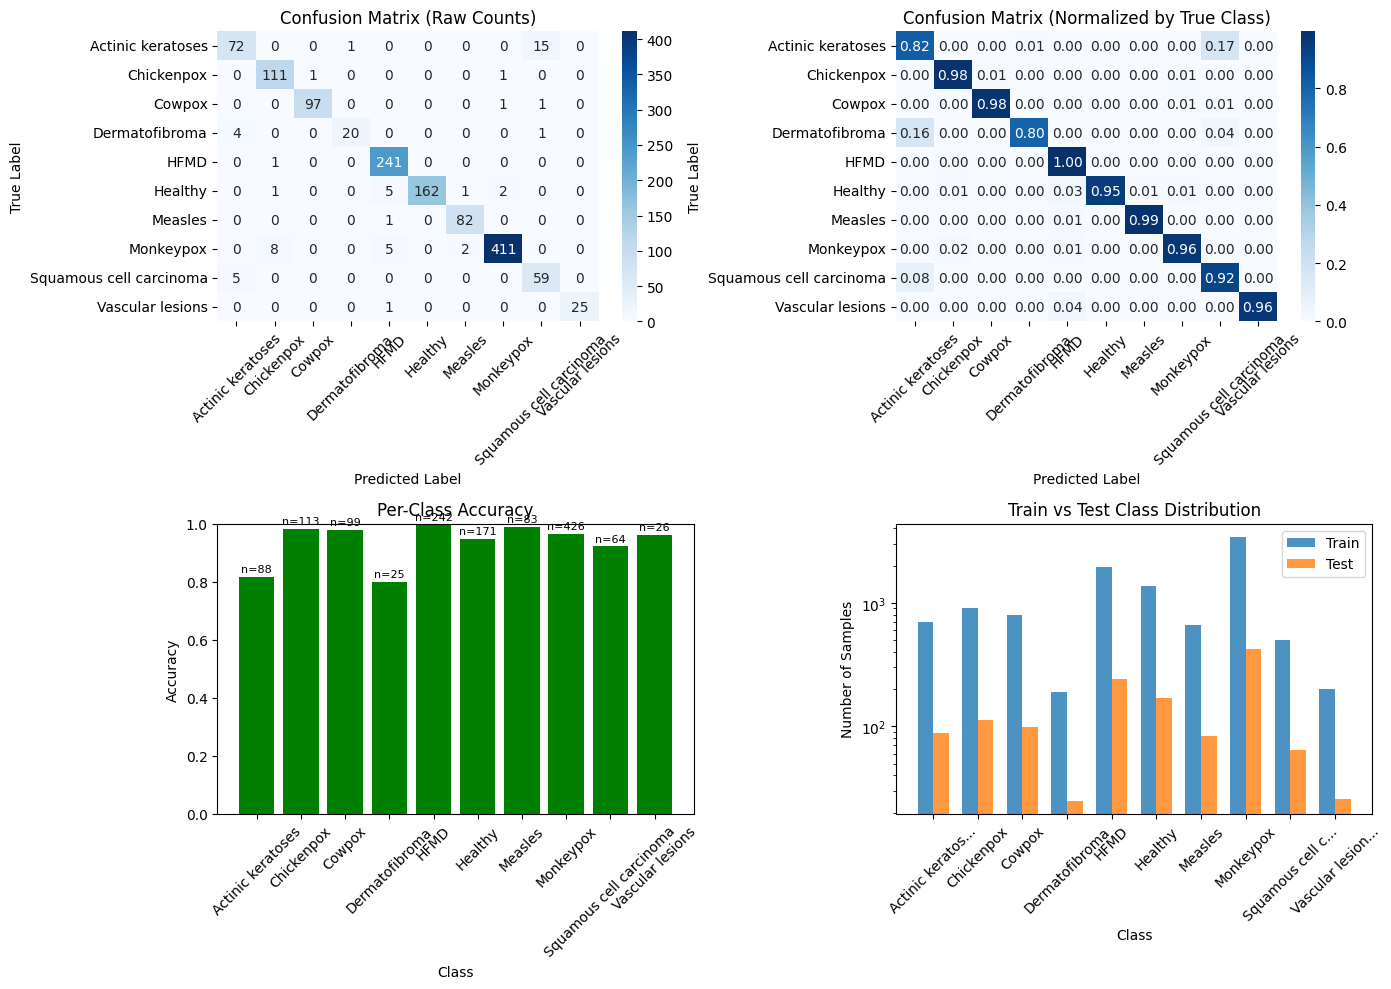


DIAGNOSTIC INFORMATION

Classes with poor performance (accuracy < 0.1):

Model's prediction bias (most frequently predicted classes):
  Monkeypox: 415 predictions (31.0%)
  HFMD: 253 predictions (18.9%)
  Healthy: 162 predictions (12.1%)
  Chickenpox: 121 predictions (9.1%)
  Cowpox: 98 predictions (7.3%)

Suggestions for improvement:
1. The model appears to be heavily biased toward certain classes (especially HFMD)
2. Consider data augmentation or resampling for underrepresented classes
3. Adjust class weights more aggressively
4. Consider using focal loss instead of weighted cross-entropy
5. Ensure test set class distribution matches expected real-world distribution

✅ Saved detailed predictions to: test_predictions_detailed.csv

Misclassification summary:
Total misclassified: 57/1337 (4.3%)
Most common misclassifications:
  Actinic keratoses → Squamous cell carcinoma: 15 cases
  Monkeypox → Chickenpox: 8 cases
  Healthy → HFMD: 5 cases
  Monkeypox → HFMD: 5 cases
  Squamous cell ca

In [11]:
# Test Set Evaluation with Improved Error Handling
%pip install pandas seaborn
import torch
from torchvision import datasets
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# path to test data 
test_dir = r"C:\Users\ashan\Downloads\DL-20251011T135953Z-1-001\DL\test"
# use same transforms as val_transforms to keep inputs consistent
test_dataset = datasets.ImageFolder(test_dir, transform=val_transforms)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)

print("Test classes order:", test_dataset.classes)
print("Test size:", len(test_dataset))

# Check class distribution in test set
test_class_counts = {}
for _, label in test_dataset.samples:
    class_name = test_dataset.classes[label]
    test_class_counts[class_name] = test_class_counts.get(class_name, 0) + 1

print("\nTest set class distribution:")
for class_name, count in test_class_counts.items():
    print(f"  {class_name}: {count}")

# load best checkpoint (if you saved it during training)
ckpt_path = "MobileNetV3-Large_best.pth"   # adjust if different
try:
    state = torch.load(ckpt_path, map_location=device)
    model.load_state_dict(state)
    print(f"\n✅ Loaded checkpoint: {ckpt_path}")
except Exception as e:
    print(f"⚠️ Checkpoint load failed (using current model): {e}")

model.to(device)
model.eval()

y_true = []
y_pred = []
probs = []   # optional: predicted probabilities

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        ps = torch.softmax(outputs, dim=1)
        _, preds = torch.max(outputs, 1)

        y_true.extend(labels.cpu().numpy().tolist())
        y_pred.extend(preds.cpu().numpy().tolist())
        probs.extend(ps.cpu().numpy().tolist())

# Calculate metrics with zero_division parameter to fix warnings
print("\n" + "="*50)
print("TEST SET EVALUATION RESULTS")
print("="*50)

# Overall accuracy
accuracy = accuracy_score(y_true, y_pred)
f1_macro = f1_score(y_true, y_pred, average='macro', zero_division=0)
f1_weighted = f1_score(y_true, y_pred, average='weighted', zero_division=0)

print(f"Overall Accuracy: {accuracy:.3f}")
print(f"F1 Score (Macro): {f1_macro:.3f}")
print(f"F1 Score (Weighted): {f1_weighted:.3f}")

print("\nDetailed Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names, zero_division=0))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
print("Raw Confusion Matrix:")
print(cm)

# Enhanced confusion matrix visualization
plt.figure(figsize=(14, 10))
plt.subplot(2, 2, 1)
# Use seaborn for better heatmap
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix (Raw Counts)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.xticks(rotation=45)
plt.yticks(rotation=0)

# Normalized confusion matrix
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.subplot(2, 2, 2)
sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix (Normalized by True Class)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.xticks(rotation=45)
plt.yticks(rotation=0)

# Class-wise performance analysis
plt.subplot(2, 2, 3)
class_accuracies = []
class_support = []
for i in range(len(class_names)):
    if cm[i].sum() > 0:  # Only if class has samples
        class_acc = cm[i, i] / cm[i].sum()
        class_accuracies.append(class_acc)
        class_support.append(cm[i].sum())
    else:
        class_accuracies.append(0)
        class_support.append(0)

bars = plt.bar(range(len(class_names)), class_accuracies, 
               color=['red' if acc < 0.1 else 'orange' if acc < 0.5 else 'green' 
                      for acc in class_accuracies])
plt.title("Per-Class Accuracy")
plt.xlabel("Class")
plt.ylabel("Accuracy")
plt.xticks(range(len(class_names)), class_names, rotation=45)
plt.ylim(0, 1)

# Add support numbers on bars
for i, (bar, support) in enumerate(zip(bars, class_support)):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
             f'n={support}', ha='center', va='bottom', fontsize=8)

# Class distribution comparison
plt.subplot(2, 2, 4)
class_names_short = [name[:15] + '...' if len(name) > 15 else name for name in class_names]
# Get train counts from train_dataset if available
if 'train_dataset' in globals():
    train_class_counts = {}
    for _, label in train_dataset.samples:
        class_name = train_dataset.classes[label]
        train_class_counts[class_name] = train_class_counts.get(class_name, 0) + 1
    train_counts = [train_class_counts.get(class_names[i], 0) for i in range(len(class_names))]
else:
    train_counts = [0] * len(class_names)
test_counts = [test_class_counts.get(class_names[i], 0) for i in range(len(class_names))]

x = np.arange(len(class_names))
width = 0.35
plt.bar(x - width/2, train_counts, width, label='Train', alpha=0.8)
plt.bar(x + width/2, test_counts, width, label='Test', alpha=0.8)
plt.title("Train vs Test Class Distribution")
plt.xlabel("Class")
plt.ylabel("Number of Samples")
plt.xticks(x, class_names_short, rotation=45)
plt.legend()
plt.yscale('log')  # Log scale to better show differences

plt.tight_layout()
plt.show()

# Identify problematic classes
print("\n" + "="*50)
print("DIAGNOSTIC INFORMATION")
print("="*50)

print("\nClasses with poor performance (accuracy < 0.1):")
for i, (class_name, acc, support) in enumerate(zip(class_names, class_accuracies, class_support)):
    if acc < 0.1 and support > 0:
        print(f"  {class_name}: {acc:.3f} accuracy, {support} samples")
    elif support == 0:
        print(f"  {class_name}: No test samples available")

print("\nModel's prediction bias (most frequently predicted classes):")
pred_counts = np.bincount(y_pred, minlength=len(class_names))
for i in np.argsort(pred_counts)[::-1][:5]:  # Top 5 most predicted
    print(f"  {class_names[i]}: {pred_counts[i]} predictions ({pred_counts[i]/len(y_pred)*100:.1f}%)")

print("\nSuggestions for improvement:")
print("1. The model appears to be heavily biased toward certain classes (especially HFMD)")
print("2. Consider data augmentation or resampling for underrepresented classes")
print("3. Adjust class weights more aggressively")
print("4. Consider using focal loss instead of weighted cross-entropy")
print("5. Ensure test set class distribution matches expected real-world distribution")

# Save detailed results
filenames = [p[0] for p in test_dataset.samples]  # full relative paths
df = pd.DataFrame({
    "file": [os.path.basename(f) for f in filenames],  # Just filename, not full path
    "true_label": [class_names[i] for i in y_true],
    "pred_label": [class_names[i] for i in y_pred],
    "confidence": [round(float(np.max(p)), 4) for p in probs],
    "correct": [t == p for t, p in zip(y_true, y_pred)]
})

# Add per-class confidence statistics
df.to_csv("test_predictions_detailed.csv", index=False)
print(f"\n✅ Saved detailed predictions to: test_predictions_detailed.csv")

# Summary of misclassifications
print(f"\nMisclassification summary:")
misclassified = df[~df['correct']]
if len(misclassified) > 0:
    print(f"Total misclassified: {len(misclassified)}/{len(df)} ({len(misclassified)/len(df)*100:.1f}%)")
    print("Most common misclassifications:")
    misclass_pairs = misclassified.groupby(['true_label', 'pred_label']).size().sort_values(ascending=False)
    for (true_label, pred_label), count in misclass_pairs.head(10).items():
        print(f"  {true_label} → {pred_label}: {count} cases")
else:
    print("Perfect classification! (This is unlikely - please verify your data)")

## Notes and next steps
- Tune learning rates, batch size, augmentation.
- Consider 5-fold cross validation for robustness.
- Use mixed precision (torch.cuda.amp) to speed up training on large GPUs.
- Save final models and record results in a comparison table.